In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import pickle as pkl
import os
import seaborn as sns
import pandas as pd
import fnmatch
from scipy.stats import binom_test
from scipy.io import loadmat,savemat
from os import path
from scipy.stats import ranksums

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def findClosestPoint(values,array):
    values = np.array(values)
    array = np.array(array)
    idx = np.array([np.square(array - value).argmin() for value in values])
    return idx,array[idx]
def sigCounter(df,min_N = 3,pSig = 5e-2):
    dbMinN = df[(df.lSub>min_N)|(df.rSub>min_N)]
    nT = dbMinN.shape[0]
    nS = dbMinN[(dbMinN.Lpv<0.05)|(dbMinN.Rpv<0.05)].shape[0]
    #print nT,nS,binom_test(nS,nT,pSig),1e2*nS/nT
    try:
        prcnt = 1e2*nS/nT
    except ZeroDivisionError:
        prcnt = None
    #print nT,nS,binom_test(nS,nT,0.05)
    #print 1e2*nS/nT
    return nT,nS,prcnt,binom_test(nS,nT,pSig)
sns.set_style('white')

In [35]:
binwidth = 0.1
A = np.linspace(0,1.,1.0/binwidth+1)
binwidth = np.diff(A)[0]
corrBinsCenters = np.union1d(-1*A,A)
corrBins = corrBinsCenters-binwidth/2
corrBins = np.insert(corrBins,[corrBins.size],[corrBins[-1]+binwidth])
##########################################
SigPrcntMin = 95
sigN = []
sigPrcnt = []
SigCorrMin = []
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    absCrr = np.abs(crr)
    cSet = np.unique(absCrr)
    prcSet = 100.0*np.cumsum([(absCrr==cor).sum() for cor in cSet])/ np.math.factorial(n)
    #print n,prcSet
    SigCorrMin.append(cSet[np.where(prcSet>= SigPrcntMin)[0][0]])
#################################
for ii,cmin in enumerate(SigCorrMin):
    print ii+4,cmin

4 1.0
5 0.9
6 0.828571428571
7 0.75
8 0.714285714286
9 0.683333333333
10 0.636363636364


/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


In [27]:
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/'
xls_keys = pd.read_excel('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/files/RO-PR-dataframe-RankOrder.xls',sheetname='PRE').keys()
print xls_keys

Index([u'animal', u'lesion_extent', u'session', u'N_pCell_left',
       u'N_pCell_right', u'Ns', u'Rate_s', u'Nt', u'Rate_t', u'prct',
       u'NsDelta', u'NtDelta', u'prctDelta', u'Rate_s_Delta', u'Rate_t_delta',
       u'NsTheta', u'NtTheta', u'prctTheta', u'Rate_s_theta', u'Rate_t_theta',
       u'group'],
      dtype='object')


In [54]:
keys = np.array(['animal','session','date','N_sig_RO', 'N_all_RO','Rate_s', 'Rate_t','pv_RO','prcnt_RO','group'])
pdb = pd.DataFrame([],columns=keys)
Nmin = 4
for item in locate('awakeReplays-*RO.db',dataFolder):
    dbName = path.join(item[0],item[1])
    group = dbName.split('/')[-4]
    dday  = dbName.split('/')[-1].split('-')[-2]
    anID  = dbName.split('/')[-1].split('-')[-3]
    session = 'linearTrack'
    try:
        trjName = [path.join(item[0],item[1])for item in locate('linearTrack_Trajectory.traj','/home/chenani/dataWork/ali/MECLesion_SleepData/')
                   if ((path.join(item[0],item[1]).find((dday[0]+'ay'+dday[-1]))>0) and (path.join(item[0],item[1]).find(anID)>0))][0]
        loadFiles = True
        
    except:
        print anID
        loadFiles = False
    trj = pkl.load(open(trjName))
    tv,v = trj.getSpeed()
    tImmo = (v<0.05).sum()*1.0/tv.size*(tv[-1]-tv[0])
    awro = pkl.load(open(dbName))
    for idx,row in awro.iterrows():
        if row.lSub>3:
            if np.abs(row.Lcorr) > SigCorrMin[min(int(row.lSub - 4),len(SigCorrMin)-1)]:
                awro.Lpv[idx]-=0.96
                #print row.lSub,row.Lcorr,SigCorrMin[min(int(row.lSub - 4),len(SigCorrMin)-1)]
        if row.rSub>3:
            if np.abs(row.Rcorr) > SigCorrMin[min(int(row.rSub - 4),len(SigCorrMin)-1)]:
                awro.Rpv[idx]-=0.96
    #print group,anID,dday,'\n'
    nt,ns,prct,pv = sigCounter(awro,min_N=Nmin)
    if nt:
        pdb = pdb.append(pd.DataFrame([[anID,session,dday,ns,nt,ns/tImmo,nt/tImmo,pv,prct,group]],columns=keys),ignore_index=True)
#pdb.to_pickle('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/files/run_percentiles_05.db')

616
616
616
616


(-1, 31)

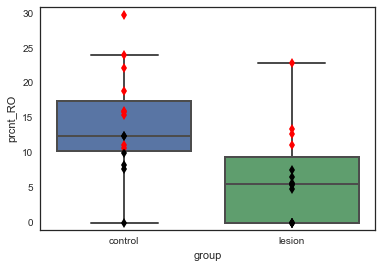

In [55]:
cdb = pdb[pdb.group=='control']
ldb = pdb[pdb.group=='lesion']
sns.boxplot(x='group',y='prcnt_RO',data=pdb[pdb.prcnt_RO>=0])
for idx,row in cdb.iterrows():
    if row.pv_RO <5e-2:
        pl.plot(0,row.prcnt_RO,'d',c='r')
    else:
        pl.plot(0,row.prcnt_RO,'d',c='k')
for idx,row in ldb.iterrows():
    if row.pv_RO <5e-2:
        pl.plot(1,row.prcnt_RO,'d',c='r')
    else:
        pl.plot(1,row.prcnt_RO,'d',c='k')
pl.ylim(-1,31)

In [57]:
keys = np.array(['animal','session','date',
                 'N_sig_RO', 'N_all_RO','Rate_s', 'Rate_t','pv_RO','prcnt_RO',
                 'NsDelta','NtDelta','prctDelta','Rate_s_Delta','Rate_t_delta','pv_del',
                 'NsTheta','NtTheta','prctTheta','Rate_s_theta','Rate_t_theta','pv_th','group'])
sldb = pd.DataFrame([],columns=keys) 
for item in locate('*roDB*.db','/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/'):
    dbName = path.join(item[0],item[1])
    group = dbName.split('/')[-5]
    dday  = dbName.split('/')[-1].split('-')[-1].split('.')[0]
    anID  = dbName.split('/')[-1].split('-')[0]
    ddday = 'Day'+ dday.split('D')[-1]
    slName = np.array([os.path.join(item[0],item[1])for item in locate('SleepEpoch*.db',dataFolder) if ((item[1].find(anID)>0)and(item[1].find(ddday)>0))])[:]
    sldf = pd.read_pickle(slName)
    sldf = sldf.replace('sleep01','PRE')
    sldf = sldf.replace('sleep05','PRE')
    sldf = sldf.replace('sleep02','POST')
    sldf = sldf.replace('sleep06','POST')
    sldf = sldf.replace('sleep03','POST')
    popro = pkl.load(open(dbName))
    popro = popro.replace('sleep01','PRE')
    popro = popro.replace('sleep05','PRE')
    popro = popro.replace('sleep02','POST')
    popro = popro.replace('sleep06','POST')
    popro = popro.replace('sleep03','POST')
    print anID,ddday,set(sldf.session),set(popro.session)
    for sess in ['PRE','POST']:
        df = popro[popro.session==sess]
        duration = np.sum(sldf[(sldf.epoch!='AWAKE')].t1-sldf[(sldf.epoch!='AWAKE')].t0)
        th_duration  = np.sum(sldf[(sldf.epoch=='REM')].t1-sldf[sldf.epoch=='REM'].t0)
        del_duration = np.sum(sldf[sldf.epoch=='SWS'].t1-sldf[sldf.epoch=='SWS'].t0)
        for idx,row in df.iterrows():
            if row.lSub>3:
                if np.abs(row.Lcorr) > SigCorrMin[min(int(row.lSub - 4),len(SigCorrMin)-1)]:
                    popro.Lpv[idx]-=0.96
                    #print row.lSub,row.Lcorr,SigCorrMin[min(int(row.lSub - 4),len(SigCorrMin)-1)]
            if row.rSub>3:
                if np.abs(row.Rcorr) > SigCorrMin[min(int(row.rSub - 4),len(SigCorrMin)-1)]:
                    popro.Rpv[idx]-=0.96
        ntT,nsT,prctT,pvT = sigCounter(df[df.epoch=='rem'],min_N=Nmin)
        ntD,nsD,prctD,pvD = sigCounter(df[df.epoch=='sws'],min_N=Nmin)
        nt,ns,prct,pv = sigCounter(df[df.epoch!='awake'],min_N=Nmin)
        if nt:
            sldb = sldb.append(pd.DataFrame([[anID,sess,dday,
                                         ns,nt,ns/duration,nt/duration,pv,prct,
                                         nsD,ntD,prctD,nsD/del_duration,ntD/del_duration,pvD,
                                         nsT,ntT,prctT,nsT/th_duration,ntT/th_duration,pvT,
                                         group]],columns=keys),ignore_index=True)

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3839 Day5 set(['PRE', 'POST']) set(['PRE', 'POST'])
614 Day3 set(['PRE', 'POST']) set(['PRE', 'POST'])
614 Day2 set(['PRE', 'POST']) set(['PRE', 'POST'])
614 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
3661 Day3 set(['PRE', 'POST']) set(['PRE', 'POST'])
3661 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
3661 Day2 set(['PRE', 'POST']) set(['PRE', 'POST'])
3906 Day2 set(['PRE', 'POST']) set(['PRE', 'POST'])
3906 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
3906 Day3 set(['PRE', 'POST']) set(['PRE', 'POST'])
3906 Day4 set(['PRE', 'POST']) set(['PRE', 'POST'])
616 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
3837 Day3 set(['PRE', 'POST']) set(['PRE', 'POST'])
3837 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
434 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
3838 Day2 set(['PRE', 'POST']) set(['PRE', 'POST'])
3838 Day3 set(['PRE', 'POST']) set(['PRE', 'POST'])
3838 Day1 set(['PRE', 'POST']) set(['PRE', 'POST'])
3838 Day4 set(['PRE', 'POST']) set(['PRE', 'POST'])
3656 Day2 set(['P

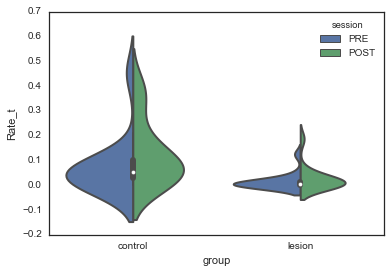

In [61]:
#sldb.to_excel('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/files/sleep_percentiles_05.xls')
sns.violinplot(x='group',y='Rate_t',data=sldb,hue='session',split=True)


In [91]:
SigPrcntMin = 95
for n in range(4,11):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    absCrr = np.abs(crr)
    cSet = np.unique(absCrr)
    prcSet = 100.0*np.cumsum([(absCrr==cor).sum() for cor in cSet])/ np.math.factorial(n)
    pl.plot(cSet[prcSet>SigPrcntMin],prcSet[prcSet>SigPrcntMin],lw=3,label=n)
pl.legend()

In [25]:
f,ax = pl.subplots(1,1)
for ii in range(4,7):
    if sigCounter(asleepDF,min_N=ii,pSig=0.1)[1]<5e-2:
        ax.plot(ii,sigCounter(asleepDF,min_N=ii,pSig=0.1)[0],'v',c='r')
        print ii
    else:
        ax.plot(ii,sigCounter(asleepDF,min_N=ii,pSig=0.1)[0],'v',c='k')

46 6 0.45870941883 13.0434782609
46 6 0.45870941883 13.0434782609
10 2 0.2639010709 20.0
10 2 0.2639010709 20.0
2 0 1.0 0.0
2 0 1.0 0.0


In [274]:
lc = asleepDF[(asleepDF.session=='sleep02')&(asleepDF.lSub>4)].Lcorr
rc = asleepDF[(asleepDF.session=='sleep02')&(asleepDF.rSub>4)].Rcorr

In [49]:
cdat = tdat[0][0][0]

In [77]:
pl.hist([cdat[0],lc,rc],corrBins,color=['r','0.8','0.7'],label=['c','l','r'],normed=True)
pl.legend()

In [282]:
s2 = asleepDF[asleepDF.session=='sleep02']
lc.size+rc.size,-np.intersect1d(lc.index,rc.index).size,cdat[0].size,df[df.session=='sleep02'].shape

(511, -203, 414, (308, 15))

In [267]:
pl.plot(lc,np.ones(lc.size),'d')
#pl.plot(rc,np.ones(rc.size)-1e-2,'d')
pl.plot(cdat[0],np.ones(cdat[0].size)+1e-2,'d')
pl.ylim(0.65,1.35)

(0.65, 1.35)

In [88]:
surrDists = loadmat('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/files/replay_DataSet/rt2.mat')['rt2'][0]

In [246]:
f,axarr = pl.subplots(2,3,figsize=[12,8])
for n in range(4,10):
    crr = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/RankOrder/corr'+str(n)+'.crr','rb'))
    srr = surrDists[n-4][1][0].T
    axarr[(n-4)/3,np.mod(n-4,3)].hist([srr,crr],corrBins,color=['k','r'],label=['Christian','Ali'],normed=True)
pl.legend()

In [312]:
s2[(s2.rSub>4)|(s2.lSub>4)].shape[0]+s2[(s2.rSub>4)^(s2.lSub>4)].shape[0]
#s24 = s2[(~np.isnan(s2.Lcorr))|(~np.isnan(s2.Rcorr))]#.shape[0]#-s2[(~np.isnan(s2.Lcorr))^(~np.isnan(s2.Rcorr))].shape[0]
#s24[(s24.lSub>4)|(s24.rSub>4)].shape

413

array([ '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3839Control/dataFiles/sleepDB/SleepEpoch-Rat3839-Day5.db'], 
      dtype='|S132')

In [83]:
sldf.t1

0       168.647
1       332.706
2       368.371
3       382.637
4       399.960
5       412.188
6       447.853
7       462.119
8       497.784
9       531.411
10      560.962
11      579.304
12      603.760
13      618.026
14      648.596
15      725.021
16      745.401
17      774.952
18      787.180
19      814.693
20      826.921
21      839.149
22     1041.930
23     1214.141
24     1230.445
25     1278.338
26     1301.775
27     1343.554
28     1375.143
29     1420.998
         ...   
114    7637.055
115    7664.568
116    7689.024
117    7743.031
118    7798.057
119    7820.475
120    7834.741
121    7875.501
122    7957.021
123    8038.541
124    8185.277
125    8219.923
126    8259.664
127    8294.310
128    8315.709
129    8342.203
130    8391.115
131    8407.419
132    8488.939
133    8537.851
134    8552.117
135    8568.421
136    8648.922
137    8696.815
138    8711.081
139    8729.423
140    8754.898
141    8940.356
142    8992.325
143    9063.655
Name: t1, dtype: float64